(2, 64, 64)
(2, 64, 64)


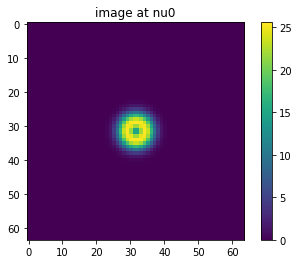

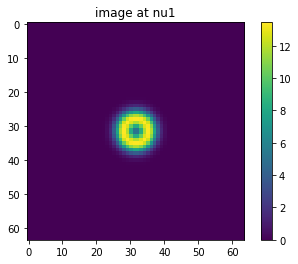

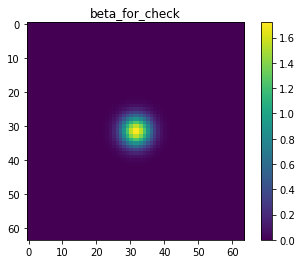

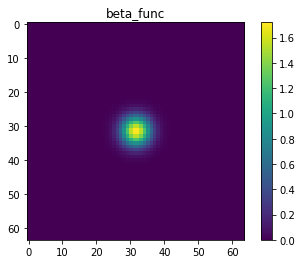

average beta: 0.7182738831809019


In [60]:
%matplotlib inline
import logging, logging.config
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger(__name__)

import os
import sys
from pathlib import Path
import pickle
import importlib


rootdir = Path().resolve()
sys.path.insert(0, os.path.abspath(os.path.join(rootdir , '../source')))
sys.path.insert(0, os.path.abspath(os.path.join(rootdir , '../config')))

from setting_freq import *


import data_make 
import matplotlib as mpl

import numpy as np
import matplotlib.pyplot as plt
import solver_mfreq as s_freq
import plot_make 
importlib.reload(s_freq)
importlib.reload(data_make)

REPLACE_OBS = True



lambda_arr = np.array([0.8, 1.5])
lambda0 = 1.0
nu_arr = 1/lambda_arr
nu0 = 1/lambda0

#Making images
beta_func = lambda xx, yy: (0.01)* data_make.gaussian_function_2d(xx, yy, 0.03, 0.03, 0,0)
input_model, xx, yy = data_make.ring_make_multi_frequency(XNUM, YNUM, DX, DY, \
    RAD_RING, WIDTH_RING, nu_arr, nu0, beta_func, function = data_make.gaussian_function_1d)
print(np.shape(input_model))


outfile = "input_model"
np.savez(outfile, model = input_model, others = beta_func(xx, yy) )
print(np.shape(input_model))
#"""
## Vertual Obervatory
obs_name = "test_observatory_mfreq"
obs_file = obs_name + ".pk"

vis_file = "vis_mfreq" + ".pk"




if not os.path.exists(obs_file) or REPLACE_OBS:
    obs_ex = data_make.observatory_mfreq(input_model, NDATA , PERIOD, \
                                         SN , OBS_DUR  , N_ANTE ,BASELINE_UVMAX, [0., 0], \
                                         lambda_arr,lambda0, save_folder = FIG_FOLDER)
    obs_ex.set_antn()
    vis_obs, num_mat, fft_now, noise = obs_ex.obs_make(DX, DY, SN)

    with open(obs_file, "wb") as f:
        pickle.dump(obs_ex, f)
        
        
    with open(vis_file, "wb") as f:
        pickle.dump((vis_obs, num_mat, fft_now, noise ), f )

else:
    
    with open(obs_file, "rb") as f:
        obs_ex = pickle.load(f) 
        
    with open(vis_file, "rb") as f:
        vis_obs, num_mat, fft_now, noise = pickle.load(f) 
        
        

## Making obs data
#vis_obs, num_mat, fft_now = obs_ex.obs_make(DX, DY, SN)
#vis_test = vis_obs


## Setting priors for model
N_tot = XNUM * YNUM
model_init = np.zeros(2 * N_tot)
model_init[0:N_tot] = 3* np.random.rand(N_tot)  

def flux_sum(arrs, width):
    n_arr, nx, ny = np.shape(arrs)
    cen = int(nx/2)
    sum_arr = []
    for i in range(n_arr):
        sum_arr.append(np.sum(arrs[i][cen-width:cen+width,cen-width:cen+width]))
    return np.array(sum_arr)
model_init[N_tot:2*N_tot] =3


grad_flag = False
plot_input = True


data = np.load("./%s.npz" % outfile)
image_nu0 = data["model"][0]
image_nu1 = data["model"][1]

if plot_input:
    plt.title("image at nu0")
    plt.imshow(image_nu0)
    plt.colorbar()
    plt.show()
    
    plt.title("image at nu1")
    plt.imshow(image_nu1)
    plt.colorbar()
    plt.show()
    
    plt.title("beta_for_check")
    beta_calc = np.log(image_nu0/image_nu1)/np.log(nu_arr[0]/nu_arr[1])
    flag = (np.isfinite(beta_calc) !=True)
    beta_calc[flag] = 0
    plt.imshow(beta_calc)
    plt.colorbar()
    plt.show()
    
    plt.title("beta_func")
    plt.imshow(beta_func(xx, yy))
    plt.colorbar()
    plt.show()
    
    
if grad_flag:
    grad_num = s_freq.grad_mfreq_numerical(model_init, vis_obs, nu_arr, nu0, lambda_l1, lambda_ltsv)
    grad_ana = s_freq.multi_freq_grad(model_init, vis_obs, nu_arr, nu0, lambda_l1, lambda_ltsv)
    plt.scatter(grad_ana, grad_num- grad_ana)
    plt.show()
    
ave_beta = np.log(np.sum(image_nu0)/np.sum(image_nu1))/np.log(nu_arr[0]/nu_arr[1])
print("average beta:",ave_beta) 

In [61]:
## Solver each frequency

def flux_sum(arrs, width):
    n_arr, nx, ny = np.shape(arrs)
    cen = int(nx/2)
    sum_arr = []
    for i in range(n_arr):
        sum_arr.append(np.sum(arrs[i][cen-width:cen+width,cen-width:cen+width]))
    return np.array(sum_arr)

import solver_mfreq as s_freq
importlib.reload(s_freq)
importlib.reload(data_make)
mult_solve_init_flag = True
## Calc grad

lambda_l1 = 1e-4
lambda_ltsv = 1e-2




if mult_solve_init_flag:
    image_I0, beta,  model_freqs = s_freq.solver_mfreq_independent(s_freq.loss_function_arr_TSV, s_freq.grad_loss_tsv, s_freq.zero_func, \
                                    vis_obs, noise, nu_arr, nu0, lambda_l1,lambda_ltsv, beta_def =1)
    
print(flux_sum([image_nu0, image_nu1],10))
print(flux_sum(model_freqs ,10))

[2275.98361829 1448.86425246]
[2050.32703104 1452.8425747 ]


In [ ]:
## Plot solutions
def count_n(arr, i):
    return len(arr[arr==i])

plt.imshow( model_freqs[0])
plt.colorbar()
plt.show()
plt.imshow( model_freqs[1])


plt.colorbar()
plt.show()
plt.imshow(image_I0)
plt.colorbar()
plt.show()
plt.imshow(beta)
plt.colorbar()
plt.show()

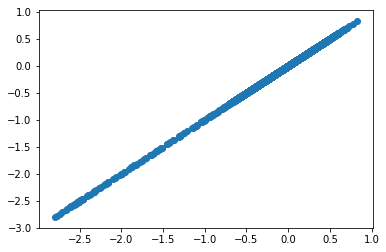

In [64]:
## Grad Check for monochromatic case
importlib.reload(s_freq)
importlib.reload(data_make)


input_model = 0.5 * model_freqs[0] + np.zeros(np.shape(model_freqs[0]))
grad_num = s_freq.grad_loss_numerical_TSV(input_model, vis_obs[0], noise[0], lambda_l1, lambda_ltsv)
grad_ana_chi, grad_ana_tsv = s_freq.grad_loss_arr_TSV(input_model , vis_obs[0], noise[0], lambda_l1, lambda_ltsv)
grad_ana = grad_ana_chi + grad_ana_tsv
plt.scatter(grad_num, grad_ana)


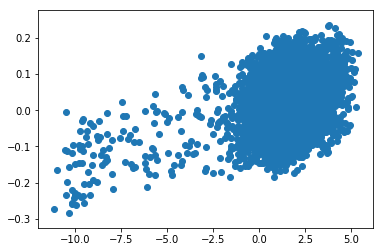

In [68]:
## Grad Check for chromatic case


result = s_freq.grad_mfreq_numerical( model_init,  vis_obs, noise ,nu_arr, nu0, lambda_l1, lambda_ltsv) 
grad_2 = s_freq.multi_freq_grad( model_init,  vis_obs, noise ,nu_arr, nu0, lambda_l1, lambda_ltsv) 

plt.scatter(result, grad_2)

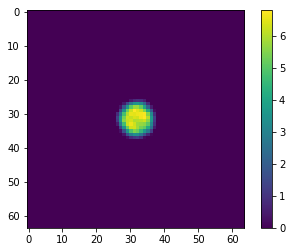

3977


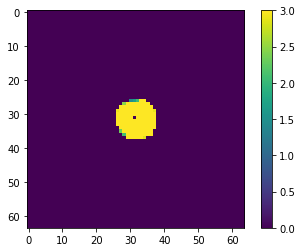

In [13]:
## Solver for chromatic case


bounds = []
for i in range(N_tot):
    bounds.append([0,30])

for i in range(N_tot):
    bounds.append([0,3])
bounds = np.array(bounds)
f_cost= s_freq.multi_freq_cost_l1_tsv
df_cost = s_freq.multi_freq_grad
models_init = np.append(image_I0, beta)
result = s_freq.solver_mfreq(f_cost,df_cost, model_init, bounds,  vis_obs, noise ,nu_arr, nu0, lambda_l1, lambda_ltsv) 
image, beta = s_freq.x_to_I_beta(result[0])
np.savez('test', image=image, beta = beta)

plt.imshow(image)
plt.colorbar()
plt.show()
print(len(image[image==0]))
beta[image==0] = 0
plt.imshow(beta)
plt.colorbar()
plt.show()
